# Score Matching for a 2D Energy-Based Model

This notebook accompanies Section 8.2 of *Mathematics of Generative AI*.

**Goals**:
- Train an energy-based model using score matching
- Visualize learned score fields
- Save figures into `figs/` for inclusion in the book


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('figs', exist_ok=True)
np.random.seed(0)

## Data: 2D Gaussian Mixture

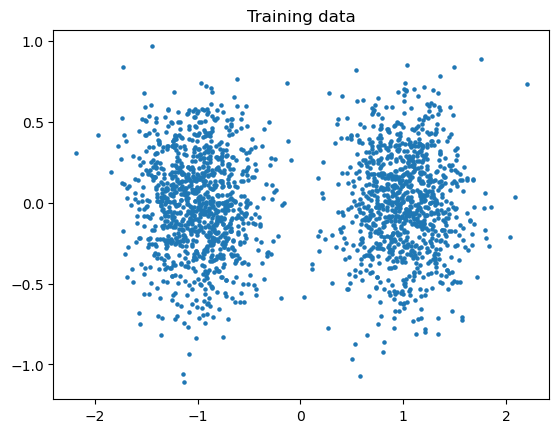

In [2]:
def sample_gmm(n=2000):
    means = [np.array([1,0]), np.array([-1,0])]
    cov = 0.1*np.eye(2)
    xs = []
    for _ in range(n):
        m = means[np.random.randint(2)]
        xs.append(np.random.multivariate_normal(m, cov))
    return np.array(xs)

X = sample_gmm()
plt.scatter(X[:,0], X[:,1], s=5)
plt.title('Training data')
plt.savefig('figs/data_scatter.png')
plt.show()

## Energy Model and Score Matching

In [3]:
import torch
import torch.nn as nn

class EnergyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64), nn.Tanh(),
            nn.Linear(64,64), nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

model = EnergyNet()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


In [4]:
X_t = torch.tensor(X, dtype=torch.float32)
for epoch in range(2000):
    X_t.requires_grad_(True)
    E = model(X_t)
    grad = torch.autograd.grad(E.sum(), X_t, create_graph=True)[0]
    loss = 0.5*(grad**2).sum(1).mean()
    opt.zero_grad(); loss.backward(); opt.step()
    if epoch%500==0:
        print(epoch, loss.item())

0 0.006905201822519302
500 8.462666301056743e-07
1000 1.8016265812548227e-07
1500 7.803745916135085e-08


## Visualizing the Learned Score Field

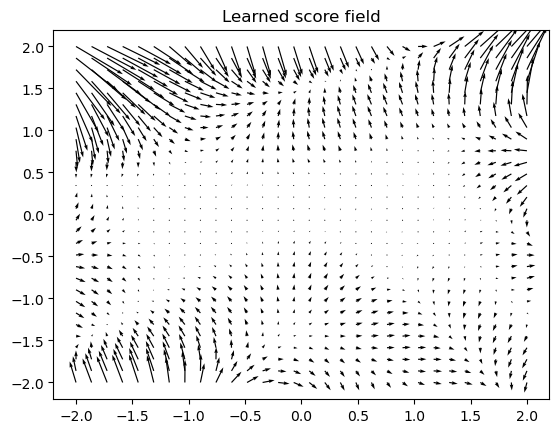

In [5]:
xx,yy = np.meshgrid(np.linspace(-2,2,30), np.linspace(-2,2,30))
grid = np.stack([xx.ravel(), yy.ravel()],1)
grid_t = torch.tensor(grid, dtype=torch.float32, requires_grad=True)
E = model(grid_t)
grad = torch.autograd.grad(E.sum(), grid_t)[0].detach().numpy()
plt.quiver(grid[:,0], grid[:,1], -grad[:,0], -grad[:,1])
plt.title('Learned score field')
plt.savefig('figs/score_field.png')
plt.show()